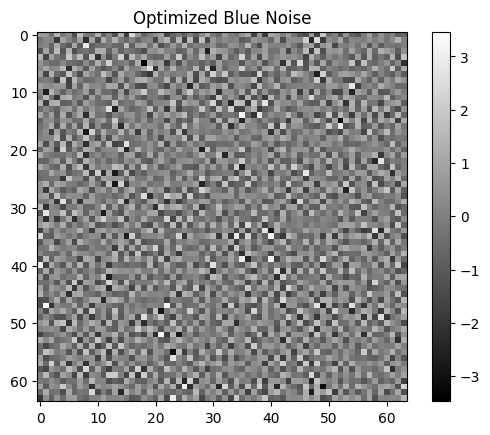

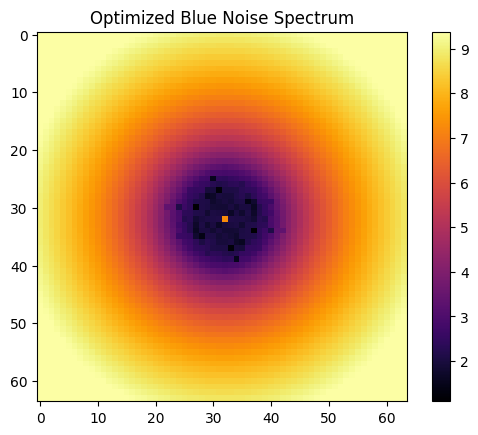

In [37]:
import torch
import torch.fft
import matplotlib.pyplot as plt

#creating noise using gradient descent

def create_frequency_grid(H, W, device):
    """
    Create a grid of radial frequency magnitudes for an HxW image.
    Uses torch.fft.fftfreq to generate frequency bins.
    """
    # Get frequencies for each axis
    fy = torch.fft.fftfreq(H, d=1.0, device=device)
    fx = torch.fft.fftfreq(W, d=1.0, device=device)
    # Create a meshgrid (using 'ij' indexing so that fy corresponds to rows)
    fy_grid, fx_grid = torch.meshgrid(fy, fx, indexing='ij')
    # Compute the radial frequency
    f_grid = torch.sqrt(fx_grid**2 + fy_grid**2)
    return f_grid
def compute_histogram(image, bins=256):
    """Compute normalized histogram of a grayscale image"""
    hist = torch.histc(image.float(), bins=bins, min=0, max=255)
    hist = hist / hist.sum()  # Normalize to get a probability distribution
    return hist
def compute_batch_histograms(images, bins=256):
    """Compute normalized histograms for a batch of grayscale images"""
    B, H, W = images.shape  # Get batch size, height, width
    images = images.reshape(B, -1)  # Flatten each image to (B, H*W)
    
    # Compute histograms for each image
    histograms = torch.stack([torch.histc(img.float(), bins=bins, min=0, max=255) for img in images])
    
    # Normalize histograms
    histograms = histograms / histograms.sum(dim=1, keepdim=True)
    
    return histograms  # Shape: (B, bins)
def l2_distance(hist1, hist2):
    """Compute L2 distance between two histograms"""
    return torch.norm(hist1 - hist2, p=2)

def l2_distance_batch(hist1, hist2):
    """Compute L2 distance between corresponding histograms in two batches"""
    return torch.norm(hist1 - hist2, p=2, dim=1)  # Shape: (B,)
def optimize_noise(B, H, W, target_fn, iterations=1000, lr=0.1, lambda_reg=0.0, device='cpu'):
    """
    Optimize a batch (B) of HxW noise patterns to match a target Fourier power spectrum.

    Args:
        B: Batch size.
        H, W: Image dimensions.
        target_fn: Function that maps a frequency grid to the desired power spectrum.
        iterations: Number of optimization iterations.
        lr: Learning rate.
        lambda_reg: Regularization weight.
        device: 'cpu' or 'cuda'.

    Returns:
        Initial and optimized noise tensors.
    """
    # Initialize white noise
    x = torch.randn((B, H, W), dtype=torch.float32, device=device, requires_grad=True)
    orig = x.clone().detach()

    optimizer = torch.optim.Adam([x], lr=lr)

    # Precompute frequency grid and mask
    f_grid = create_frequency_grid(H, W, device).unsqueeze(0)  # Expand for batch processing
    mask = (f_grid > 1e-6).float()  # Avoid DC component

    # Compute initial power spectrum statistics
    with torch.no_grad():
        x_fft = torch.fft.fft2(x)
        white_power = torch.abs(x_fft) ** 2
        mean_white_power = (white_power * mask).sum(dim=[1, 2]) / mask.sum()

    # Compute the scaled target spectrum
    target_vals = target_fn(f_grid)  # Shape: (1, H, W)
    mean_target_val = (target_vals * mask).sum(dim=[1, 2]) / mask.sum()
    scale_factor = mean_white_power / (mean_target_val + 1e-8)
    target_spec = scale_factor.view(B, 1, 1) * target_vals  # Match batch dimensions

    for i in range(iterations):
        optimizer.zero_grad()
        fft_x = torch.fft.fft2(x)
        power_spectrum = torch.abs(fft_x) ** 2

        # Compute spectral loss
        spectral_loss = ((power_spectrum - target_spec) ** 2 * mask).mean(dim=[1, 2])  # Shape: (B,)

        # Histogram loss (batch-wise)

        # Regularization loss (optional)
        variance_loss = (x.std(dim=[1, 2]) - orig.std(dim=[1, 2])) ** 2 if lambda_reg > 0 else 0.0  # Shape: (B,)

        # Aggregate loss into a scalar
        loss = torch.sum(spectral_loss) + lambda_reg * variance_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Print loss occasionally
        # if (i + 1) % (iterations // 10) == 0 or i == 0:
        #     print(f"Iteration {i+1}/{iterations}, Loss: {loss.item():.6f}")

    return orig, x.detach()

def plot_noise(x, title="Noise"):
    """Plot the noise image."""
    plt.figure()
    plt.imshow(x.cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def plot_power_spectrum(x, title="Power Spectrum"):
    """Compute and plot the log power spectrum of the noise image."""
    fft_x = torch.fft.fft2(x)
    # Add a small constant to avoid log(0)
    power_spectrum = torch.log(torch.abs(fft_x)**2 + 1e-8)
    # Shift the zero frequency component to the center for visualization
    power_spectrum = torch.fft.fftshift(power_spectrum)
    plt.figure()
    plt.imshow(power_spectrum.cpu().numpy(), cmap='inferno',interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Set device: GPU if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
B,H, W = 50,64, 64  # Image dimensions
def piecewise_blue_noise_target(f, f_threshold=0.1, exponent=4.0):
    """
    Piecewise target spectrum: Suppresses low frequencies with a power-law,
    while leaving mid and high frequencies unchanged.

    Args:
        f: Frequency grid (tensor).
        f_threshold: Frequency threshold below which suppression is applied.
        exponent: Controls the strength of low-frequency suppression.

    Returns:
        A tensor with suppressed low frequencies and constant mid/high frequencies.
    """
    target = torch.ones_like(f)
    low_mask = f < f_threshold
    # For low frequencies, scale them nonlinearly; normalize by f_threshold to keep values in [0,1]
    target[low_mask] = (f[low_mask] / f_threshold) ** exponent
    return target
def piecewise_red_noise_target(f, f_threshold=0.5, exponent=4.0):
    target = torch.ones_like(f)
    low_mask = f > f_threshold
    # For low frequencies, scale them nonlinearly; normalize by f_threshold to keep values in [0,1]
    target[low_mask] = (f[low_mask] / f_threshold) ** exponent
    return target
def piecewise_donut_noise_target(f, f_threshold_l=0.35,f_threshold_h=0.7, exponent_l=4.0,exponent_h=0.25):
    target = torch.ones_like(f)
    low_mask = f < f_threshold_l
    high_mask = f > f_threshold_h
    # For low frequencies, scale them nonlinearly; normalize by f_threshold to keep values in [0,1]
    target[low_mask] = (f[low_mask] / f_threshold_l) ** exponent_l
    target[high_mask] = (f[high_mask] / f_threshold_h) ** exponent_h
    return target
# Define the target function for blue noise.
# Blue noise is characterized by low energy at low frequencies,
# so a common choice is a target spectrum that grows as f^2.
blue_noise_target = lambda f: piecewise_blue_noise_target(f,0.55,4.5) 
green_noise_target = lambda f: piecewise_donut_noise_target(f,0.35,0.5,6,-4)
red_noise_target = lambda f: piecewise_red_noise_target(f,0.3,-4) #v15, 0.35,4,50 #v16 0.25,3,50 
iterations = 500
# Optimize the noise to match the blue noise spectrum.
orig, optimized_noise = optimize_noise(B,H, W, blue_noise_target, iterations=iterations, lr=0.1, lambda_reg=0.0, device=device)

# Plot the resulting noise and its power spectrum.
plot_noise(optimized_noise[0], title="Optimized Blue Noise")
plot_power_spectrum(optimized_noise[0], title="Optimized Blue Noise Spectrum")

In [38]:
#generating total_amount of noisetype masks
import numpy as np
from tqdm import tqdm
import os
total_amount = 100000
batch_size = 5000
noisetype = "purplev3"
os.makedirs(f"noise_masks_{noisetype}",exist_ok=True)
output_tensor = np.zeros(shape=(total_amount,64,64))
for i in tqdm(range(total_amount//batch_size)):
    __, masks =  optimize_noise(batch_size,64, 64, blue_noise_target, iterations=iterations, lr=0.1, lambda_reg=0.0, device=device)
    #plot_power_spectrum(masks[0], title="Optimized Blue Noise Spectrum")
    output_tensor[i * batch_size:(i + 1) * batch_size] = masks.cpu().numpy()
np.save(f"noise_masks_{noisetype}/masks.npy",output_tensor)

100%|██████████| 20/20 [02:34<00:00,  7.74s/it]


In [ ]:
#creating the covariance matrix L
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
noisetype = 'bluev22'
def compute_average_covariance_rgbv2(size,noisetype, load_dir="noise_masks"):
    """
    Loads K RGB masks from disk, flattens each (size, size, 3) into a 1D vector
    of length 3 * size * size, and computes the average covariance matrix.
    
    The resulting covariance matrix will be of shape (3*size*size, 3*size*size).
    """
    load_dir = f"{load_dir}_{noisetype}"
    
    num_pixels = size * size  # Flattened length for each RGB mask
    M = np.load(os.path.join(load_dir, f"masks.npy"))
    M = M.reshape(M.shape[0],size*size)
    print(f"number of masks: {M.shape[0]}")

    # Subtract mean for each pixel across K samples
    M_mean = M.mean(axis=0, keepdims=True)
    M_centered = M - M_mean
    cov_matrix = (M_centered.T @ M_centered) / (M.shape[0] - 1)
    cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-8
    return cov_matrix
cov = compute_average_covariance_rgbv2(64,noisetype=noisetype)
L = np.linalg.cholesky(cov)
i = 0
plt.imshow(L[i:i+64,i:i+64],cmap='gray',axs='off')
os.makedirs("covariances",exist_ok=True)
np.save(f"covariances/L_cov_{noisetype}", L)

(-0.5, 63.5, 63.5, -0.5)

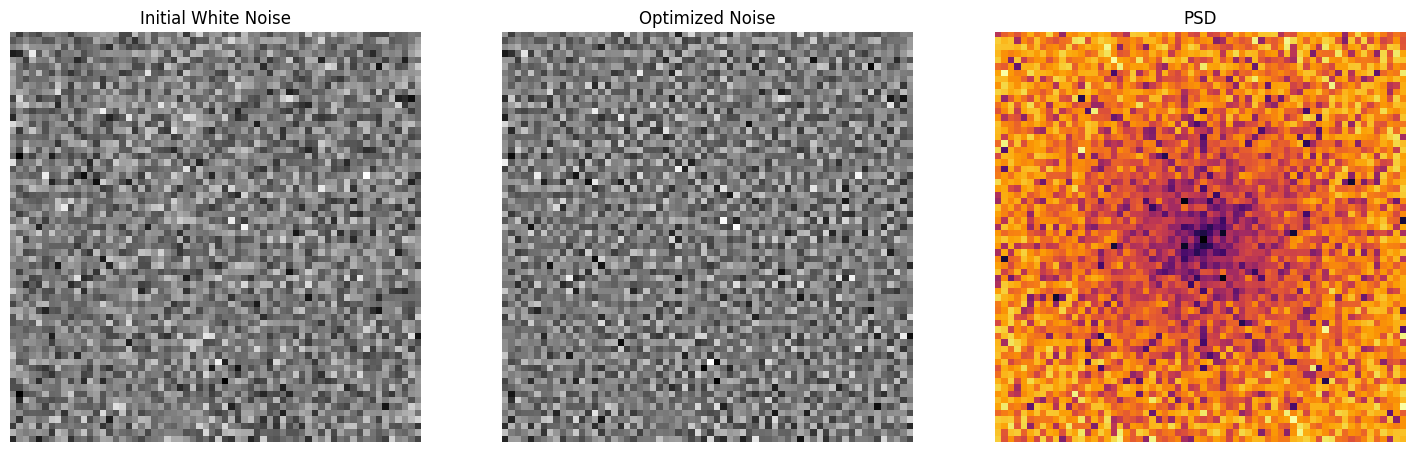

In [36]:
#creating blue noise using direct amplitude replacing
import torch
import torch.fft
import matplotlib.pyplot as plt
import numpy as np

def create_frequency_grid(H, W, device):
    """
    Create a grid of radial frequency magnitudes for an HxW image.
    """
    fy = torch.fft.fftfreq(H, d=1.0, device=device)
    fx = torch.fft.fftfreq(W, d=1.0, device=device)
    fy_grid, fx_grid = torch.meshgrid(fy, fx, indexing='ij')
    f_grid = torch.pow((fx_grid**2 + fy_grid**2),0.4)
    return f_grid

def generate_blue_noise(batch_size, H, W, device='cpu'):
    """
    Generate blue noise by directly shaping the Fourier spectrum of white noise.

    The process:
      1. Generate white noise in batches and compute its FFT.
      2. Extract the amplitude and phase.
      3. Replace the amplitude with one proportional to the frequency (f)
         to enforce a power spectrum ~ f^2.
      4. Combine the new amplitude with the original phase and compute the inverse FFT.

    Parameters:
      batch_size (int): Number of noise masks to generate.
      H (int): Height of each noise mask.
      W (int): Width of each noise mask.
      device (str): Device for computation, e.g. 'cpu' or 'cuda'.

    Returns:
      tuple: A tuple of numpy arrays (white_noise, blue_noise) each with shape (batch_size, H, W).
    """
    import torch

    # Generate white noise in batches
    white_noise = torch.randn(batch_size, H, W, device=device)
    noise_fft = torch.fft.fft2(white_noise)

    # Separate amplitude and phase
    amplitude = torch.abs(noise_fft)
    phase = torch.angle(noise_fft)

    # Create frequency grid (assumed to return a tensor of shape (H, W))
    f = create_frequency_grid(H, W, device)
    eps = 1e-8
    f_adjusted = torch.where(f == 0, torch.tensor(eps, device=device), f)

    # The frequency grid is automatically broadcasted to (batch_size, H, W)
    target_amplitude = amplitude * f_adjusted

    # Reconstruct FFT using the target amplitude and original phase
    new_fft = target_amplitude * torch.exp(1j * phase)
    blue_noise = torch.real(torch.fft.ifft2(new_fft))

    return white_noise.detach().cpu().numpy(), blue_noise.detach().cpu().numpy()

def plot_noise(noise, title="Noise"):
    plt.figure()
    plt.imshow(noise.cpu().numpy(), cmap='gray', interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
H, W = 64, 64
B = 1000
# Generate blue noise using direct spectral shaping
white_noise,blue_noise = generate_blue_noise(B,H, W, device)


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Visualize the resulting blue noise
axs[0].imshow(white_noise[0], interpolation='nearest',cmap='gray')
axs[0].set_title("Initial White Noise")
axs[0].axis('off')

axs[1].imshow(blue_noise[0], interpolation='nearest',cmap='gray')
axs[1].set_title(f"Optimized Noise")
axs[1].axis('off')

x = blue_noise[0]
F = np.fft.fftshift(np.fft.fft2(x))
power_spectrum = np.log(np.abs(F)**2 + 1)

axs[2].imshow(power_spectrum, cmap='inferno', interpolation='nearest')
axs[2].set_title("PSD")
axs[2].axis('off')

In [52]:
directory = 'noise_masks_bluev8'
total_amount = 50000
batch_size = 5000
for i in range(total_amount//batch_size):
    __, masks =  generate_blue_noise(5000,64, 64, device)
    for j in range(batch_size):
        np.save(f'noise_masks_bluev8/mask_{i*batch_size + j}',masks[j])
